/var/folders/l_/1vjbdzb93s15yn8xfv9ntcjr0000gn/T/ipykernel_11704/2433879493.py:22: RuntimeWarning: overflow encountered in exp
  n1_tm1 = 1/ (1+np.exp(beta*(g2_tm1 - g1_tm1)))


[3.02218045] [0.06054456]
[4.56864179] [0.30012261]


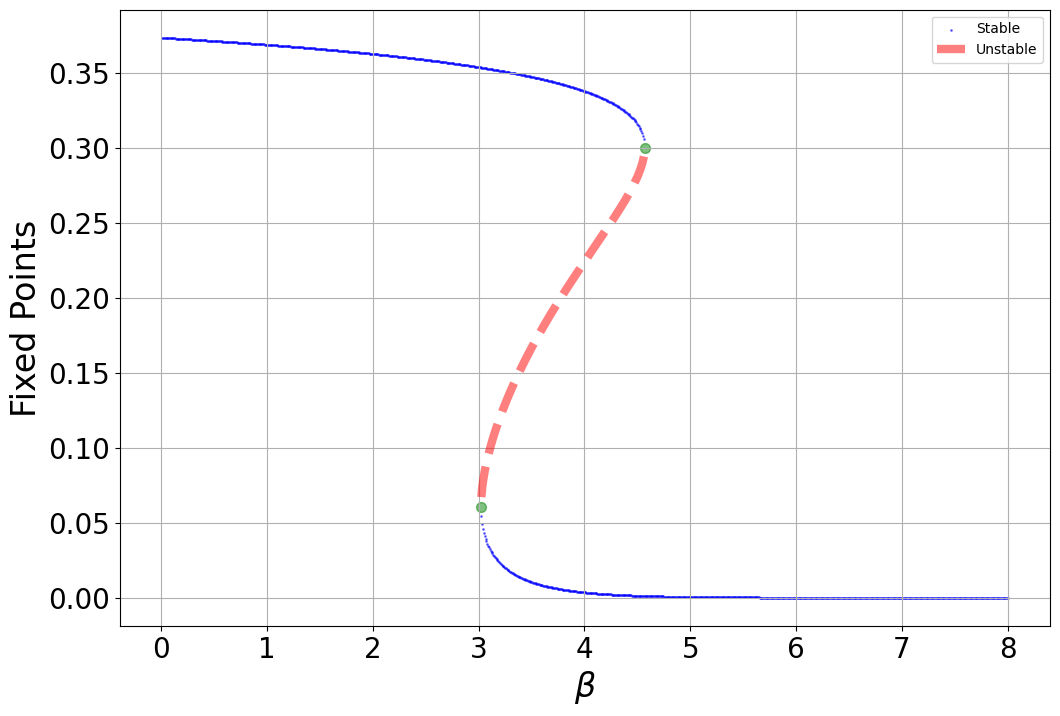

In [1]:
#--------------------------------FOR N=6--------------------------------


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root

# Define the system parameters
R = 1.2
k1=0.5
k2=1.1
k3 = 0.01


def x_next(x_tm1, x_tm2, x_tm3, v_00, beta):
    g1_tm1 = -(v_00*0.5)*(x_tm1 - k1)**2
    g2_tm1 = -(v_00*0.5)*(x_tm1 - k2 * (np.tanh(x_tm3)) - k3 * (x_tm3))**2
    
    exp_beta_g1 = np.exp(beta * g1_tm1)
    exp_beta_g2 = np.exp(beta * g2_tm1)
    
    n1_tm1 = 1/ (1+np.exp(beta*(g2_tm1 - g1_tm1)))
    n2_tm1 = 1-n1_tm1
    
    h1 = k1
    h2 = k2 * (np.tanh(x_tm1)) + k3 * (x_tm1)
    
    x_next_val = (1 / R) * (n1_tm1 * h1 + n2_tm1 * h2)
    
    return x_next_val

def find_fixed_points(v_00,beta):
    def fixed_point_eq(x):
        return x_next(x, x, x, v_00, beta) - x
    
    x_guess = np.linspace(0, 5, 100)
    fixed_points = []
    
    for guess in x_guess:
        result = root(fixed_point_eq, guess, method='hybr')
        if result.success and abs(fixed_point_eq(result.x)[0]) < 1e-8:  # Relaxed tolerance
            if not any(np.isclose(result.x[0], fp, atol=1e-8) for fp in fixed_points):
                fixed_points.append(result.x[0])
    
    return fixed_points

def calculate_n1_star(x_star, v_00, beta):
    g1_star = -(v_00*0.5)*(x_star - k1)**2
    g2_star = -(v_00*0.5)*((1 - k3) * x_star - k2 * np.tanh(x_star))**2
    
    exp_beta_g1_star = np.exp(beta * g1_star)
    exp_beta_g2_star = np.exp(beta * g2_star)
    
    n1_star = 1 / (1+np.exp(beta*(g2_star -g1_star)))
    
    return n1_star

def classify_stability(x_star, v_00, beta):
    
        n1_star = calculate_n1_star(x_star, v_00, beta)
        
        y= beta* (v_00*0.5)* ((x_star - k1)**2 - ((1 - k3) * x_star - k2 * np.tanh(x_star))**2)
        
        c1 =(1 / R) * (n1_star**2 * 2 * beta *(v_00*0.5) * np.exp(y)* (k1 - (k2 * np.tanh(x_star) + k3 * x_star))**2 + (1 - n1_star) * ((k2 / (np.cosh(x_star)**2)) + k3))
        c2 =(1 / R) * (-n1_star**2 * 2 * (v_00*0.5)* beta * np.exp(y) * ((1 - k3) * x_star - k2 * np.tanh(x_star)) * ((k2 / (np.cosh(x_star)**2)) + k3) * (k1 - k2 * np.tanh(x_star) - k3 * x_star))
        p1=-c1
        p3=-c2
        
#        if np.abs(c1+c2)<1 and np.abs(c1+c2)< 1-c2**2:
        if np.abs(p1+p3) < 1 and np.abs(p1*p3) < (1-(p3**2)):
            return 0  # stable
        elif np.abs(1-(c1+c2)) < 1e-3:
            return 2 #saddle
        else:
            return 1  # unstable

def bifurcation_diagram(v_00, betas):
    betas_plot = []
    x_plot = []
    stability = []

    
    for beta in betas:
        fixed_points = find_fixed_points(v_00, beta)
        for fp in fixed_points:
            stab = classify_stability(fp, v_00, beta)
            betas_plot.append(beta)
            x_plot.append(fp)
            stability.append(stab)
    

    return np.array(betas_plot), np.array(x_plot), np.array(stability)


def save_bifurcation_data(filename, betas_plot, x_plot, stability):
    combined_data = np.column_stack((betas_plot, x_plot, stability))
    np.savetxt(filename, combined_data, delimiter=',', header='beta,x,stability', comments='')


betas = np.linspace(0.01, 8, 1000)
beta1 = np.linspace(2.95, 3.05, 400)
beta2 = np.linspace(4.5, 4.6, 2600)

# Generate bifurcation diagram
betas_plot, x_plot, stability = bifurcation_diagram(14.900565885206147,betas)
beta1_plot, x1_plot, stability1 = bifurcation_diagram(14.900565885206147,beta1)
beta2_plot, x2_plot, stability2 = bifurcation_diagram(14.900565885206147,beta2)
    
    
save_bifurcation_data('data0_n=6.txt', betas_plot, x_plot, stability)
save_bifurcation_data('data1_n=6.txt', beta1_plot, x1_plot, stability1)  
save_bifurcation_data('data2_n=6.txt', beta2_plot, x2_plot, stability2)   
        

print(beta1_plot[stability1 == 2], x1_plot[stability1 == 2])
print(beta2_plot[stability2 == 2], x2_plot[stability2 == 2])



def read_bifurcation_data(filename):
    return np.loadtxt(filename, delimiter=',', skiprows=1)

def plot_bifurcation_diagram(filenames):
    plt.figure(figsize=(12, 8))
    
    for i, filename in enumerate(filenames):
        data = read_bifurcation_data(filename)
        betas, x_values, stability = data.T  # Transpose to get columns
        
        if i == 0:  # Main bifurcation diagram
            plt.scatter(betas[stability == 0], x_values[stability == 0], 
                s=1, c='blue', alpha=0.5, label='Stable')
            plt.plot(betas[stability == 1], x_values[stability == 1], 
                'r--', label='Unstable', alpha=0.5,linewidth=6)
        else:  # Saddle-node bifurcations
            plt.scatter(betas[stability == 2], x_values[stability == 2], 
                s=50, c='green', alpha=0.5)
    
    plt.xlabel(r'$\beta$', fontsize=24)
    plt.ylabel('Fixed Points', fontsize=24)
    plt.legend()
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
  #  plt.ylim(0, 0.5)
  #  plt.xlim(0, )

# List of files to plot
files_to_plot = ['data0_n=6.txt', 'data1_n=6.txt', 'data2_n=6.txt']

# Plot the bifurcation diagram
plot_bifurcation_diagram(files_to_plot)

plt.savefig('n=6.jpg', dpi=300, bbox_inches='tight')
plt.show()